In [1]:
import classy
from classy import Class

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import emcee
import torch
_ = torch.manual_seed(0)

In [4]:
torch.device('mps')

device(type='mps')

# Toy SBI comparison notebook

### Generate known test CMB $C^{TT}_\ell$ 

In [24]:

def get_unlensed_TT(
    H0=67.5,
    ombh2=0.022,
    omch2=0.122,
    tau_reio=0.06,
    logA=3.04,   # ln(10^{10} A_s)
    ns=0.965,
    lmax=3000,
    lmin=2,
    n_bins=50,
):
    """
    Compute the unlensed TT C_ell from CLASS.
    Returns ℓ and C_ell^TT(unlensed).
    """
    cosmo = Class()
    cosmo.set({
        "h":         float(H0)/100.0,
        "omega_b":      float(ombh2),
        "omega_cdm":      float(omch2),
        "tau_reio":   float(tau_reio),
        "ln10^{10}A_s": float(logA),
        "n_s":         float(ns),

        "output":       "tCl",    # temperature Cls
        "lensing":      "no",     # unlensed
        "l_max_scalars": lmax,
    })
    cosmo.compute()

    # unlensed Cls
    cl = cosmo.raw_cl(lmax)     

    ell = cl["ell"][lmin:]
    unlensed_TT = cl["tt"][lmin:]

    cosmo.struct_cleanup()
    cosmo.empty()
    factor = 1.e10*ell*(ell+1.)/2./np.pi
    cl_tt = factor*unlensed_TT
    # logarithmic binning

    bin_edges = np.unique(np.logspace(np.log10(lmin), np.log10(lmax), n_bins+1).astype(int))
    n_bins_actual = len(bin_edges) - 1

    ell_binned = np.zeros(n_bins_actual)
    cl_binned = np.zeros(n_bins_actual)

    for i in range(n_bins_actual):
        mask = (ell >=bin_edges[i]) & (ell < bin_edges[i+1])
        
        if np.sum(mask)>0:
            weights = ell[mask]
            ell_binned[i] = np.average(ell[mask], weights=weights)
            cl_binned[i] = np.average(cl_tt[mask], weights=weights)
        else:
            ell_binned[i] = (bin_edges[i] + bin_edges[i+1]) / 2.0
            cl_binned[i] = np.nan

    return ell_binned, cl_binned
def add_gauss_noise(signal, mu=0.0, sigma=0.1, amp=1.0):
    return signal + (amp * np.random.normal(mu,sigma,size=signal.shape))


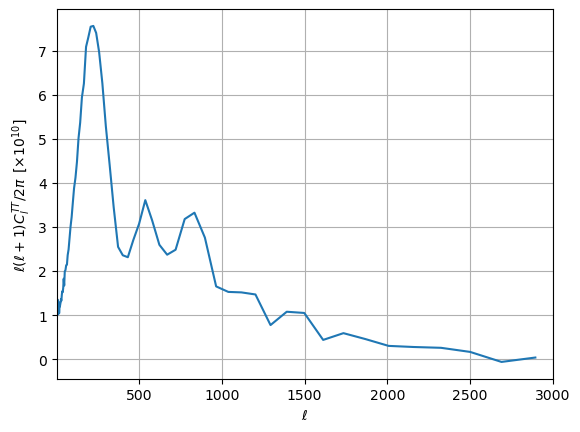

In [32]:
H0      = 67.5
ombh2   = 0.022
omch2   = 0.122
tau     = 0.06
logA    = 3.04
ns      = 0.965
# Generate unbinned spectrum
ell, cl_tt = get_unlensed_TT(lmax=3000, lmin=2, n_bins=100)

npspec = add_gauss_noise(cl_tt)
testspec = torch.from_numpy(npspec.astype(np.float32))


plt.plot(ell,testspec)
plt.xlim([2,3000])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\ell (\ell+1) C_l^{TT} / 2 \pi \,\,\, [\times 10^{10}]$")
plt.grid()
  

### now generate some simulated spectra 

In [36]:
def simulator(theta: torch.Tensor,
              lmax: int = 3000,
              lmin: int = 2,
              n_bins: int = 100) -> torch.Tensor:
    theta = theta.detach().cpu().numpy()
    specs = []
    for pars in theta:
        H0, ombh2, omch2, tau_reio, logA, ns = pars
        _, unlensed_TT = get_unlensed_TT(
            H0=H0,
            ombh2=ombh2,
            omch2=omch2,
            tau_reio=tau_reio,
            logA=logA,
            ns=ns,
            lmax=lmax,
            lmin=lmin,
            n_bins=n_bins,  # add binning parameter
        )
        noisy = add_gauss_noise(unlensed_TT, mu=0.0, sigma=0.1, amp=1.0)
        specs.append(noisy.astype(np.float32))
    specs = np.stack(specs, axis=0)
    return torch.from_numpy(specs)

In [34]:
import sbi 
print(sbi.__version__)

0.25.0


In [35]:
from sbi.utils import BoxUniform
prior = BoxUniform(
    low=torch.tensor([60.0, 0.02, 0.10, 0.03, 2.5, 0.9]),
    high=torch.tensor([75.0, 0.025, 0.14, 0.09, 3.5, 1.05]),
)

In [37]:
from sbi.inference import NPE, simulate_for_sbi
inference = NPE(prior=prior)
theta, x = simulate_for_sbi(simulator, prior, 10000, simulation_batch_size = 100)
print("theta.shape", theta.shape)
print("x.shape", x.shape)

  0%|          | 0/100 [00:00<?, ?it/s]

theta.shape torch.Size([10000, 6])
x.shape torch.Size([10000, 85])


In [38]:
inference = inference.append_simulations(theta, x)
density_estimator = inference.train()
posterior = inference.build_posterior()
print(posterior)

x_obs = testspec
samples = posterior.sample((100000,), x=x_obs)

 Neural network successfully converged after 97 epochs.Posterior p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


  0%|          | 0/100000 [00:00<?, ?it/s]

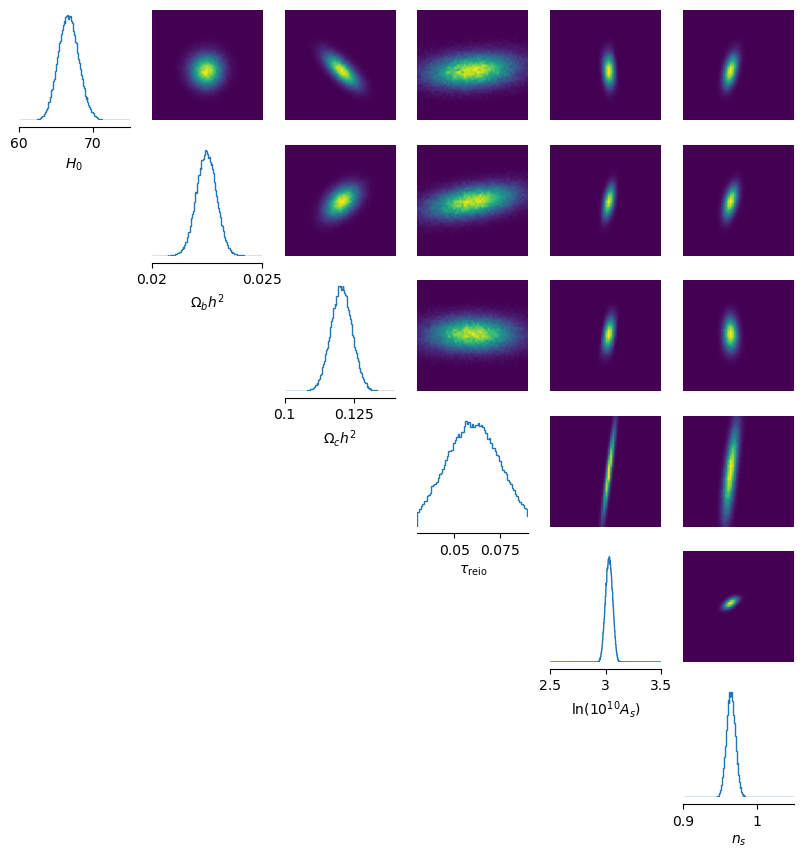

In [39]:
from sbi.analysis import pairplot

# Get prior bounds from BoxUniform
low = prior.low.detach().cpu().numpy()   # shape (6,)
high = prior.high.detach().cpu().numpy() # shape (6,)

# Build limits list: [[low0, high0], [low1, high1], ...]
limits = [[l, h] for l, h in zip(low, high)]

# Cosmological parameter labels
labels = [
    r"$H_0$",
    r"$\Omega_b h^2$",
    r"$\Omega_c h^2$",
    r"$\tau_{\rm reio}$",
    r"$\ln(10^{10}A_s)$",
    r"$n_s$",
]

_ = pairplot(
    samples,          # (Nsamples, 6)
    limits=limits,    # one [low, high] per dim from your BoxUniform
    labels=labels,
    figsize=(10, 10),
)


Sampling 500 times (1000,) posterior samples.: 100%|██████████| 500/500 [00:18<00:00, 27.62it/s]

-0.3680001497268677 Should be close to 0
0.9999999953860058 Should be larger than 0.05


(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Credibility Level $\\alpha$', ylabel='Expected Coverage Probability'>)

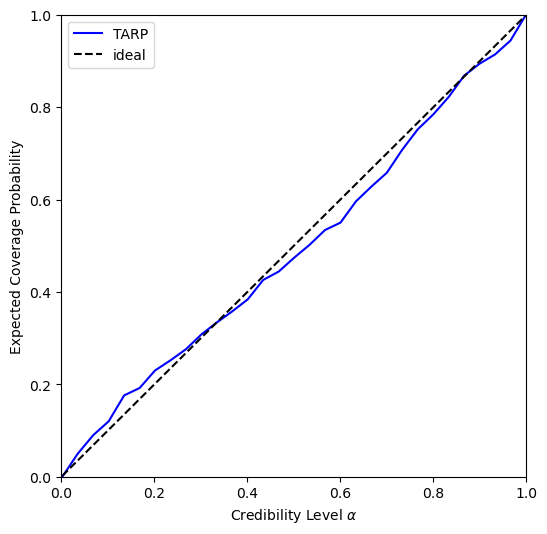

In [40]:
from sbi.diagnostics import run_tarp, check_tarp
from sbi.analysis.plot import plot_tarp

posterior = inference.build_posterior()

num_tarp_samples = 500  # choose a number of sbc runs, should be ~100s
# # generate ground truth parameters and corresponding simulated observations for SBC.
prior_samples = prior.sample((num_tarp_samples,))
prior_predictives = simulator(prior_samples)

# the tarp method returns the ECP values for a given set of alpha coverage levels.
ecp, alpha = run_tarp(
    prior_samples,
    prior_predictives,
    posterior,
    references=None,  # will be calculated automatically.
    num_posterior_samples=1000,
    use_batched_sampling=False,  # `True` can give speed-ups, but can cause memory issues.
)
# Similar to SBC, we can check then check whether the distribution of ecp is close to
# that of alpha.
atc, ks_pval = check_tarp(ecp, alpha)
print(atc, "Should be close to 0")
print(ks_pval, "Should be larger than 0.05")

plot_tarp(ecp, alpha)

### now do the sanity check with emcee


In [ ]:
prior_low  = np.array([60.0, 0.020, 0.10, 0.03, 2.5, 0.90])
prior_high = np.array([75.0, 0.025, 0.14, 0.09, 3.5, 1.05])

def log_prior(theta):
    theta = np.asarray(theta)
    if np.all((theta >= prior_low) & (theta <= prior_high)):
        return 0.0
    return -np.inf

def log_likelihood(theta, ell_obs, testspec_obs,
                   lmax=3000, lmin=2,
                   noise_sigma=0.1):
    """
    testspec ~ N(model, noise_sigma^2 I)
    """
    H0, ombh2, omch2, tau_reio, logA, ns = theta

    ell_model, tt_model = get_unlensed_TT(
        H0, ombh2, omch2, tau_reio, logA, ns,
        lmax=lmax, lmin=lmin,
    )

    resid = testspec_obs - tt_model
    chi2 = np.sum((resid / noise_sigma) ** 2)
    return -0.5 * chi2


def log_posterior(theta, ell_obs, testspec_obs,
                  lmax=3000, lmin=2,
                  noise_sigma=0.1):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, ell_obs, testspec_obs,
                               lmax=lmax, lmin=lmin,
                               noise_sigma=noise_sigma)


In [73]:
import emcee

ndim = 6
nwalkers = 32
nsteps = 2000   
burnin = 500

theta_center = 0.5 * (prior_low + prior_high)


init_spread = (prior_high - prior_low) * 0.2   # 20% of prior width
p0 = theta_center + init_spread * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_posterior,
    args=(ell, npspec),
)

print("Running emcee...")
sampler.run_mcmc(p0, nsteps, progress=True)

samples_emcee = sampler.get_chain(discard=burnin, flat=True)
print("emcee samples shape:", samples_emcee.shape)


Running emcee...


100%|██████████| 2000/2000 [6:14:53<00:00, 11.25s/it]    

emcee samples shape: (48000, 6)


In [ ]:
from sbi.analysis import pairplot
import torch

labels = [
    r"$H_0$",
    r"$\Omega_b h^2$",
    r"$\Omega_c h^2$",
    r"$\tau_{\rm reio}$",
    r"$\ln(10^{10}A_s)$",
    r"$n_s$",
]

limits = [[float(l), float(h)] for l, h in zip(prior_low, prior_high)]

# convert emcee samples to torch
samples_emcee_t = torch.from_numpy(samples_emcee.astype(np.float32))

# sbi samples are already in `samples` (torch)
# Example: compare just (H0, ombh2, omch2):
idx = [0, 1, 2]

_ = pairplot(
    samples=torch.cat(
        [samples[:, idx], samples_emcee_t[:, idx]],
        dim=0,
    ),
    labels=[labels[i] for i in idx],
    limits=[limits[i] for i in idx],
    figsize=(6, 6),
)
